In [107]:
import pandas as pd
import numpy as np
import sqlite3

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [199]:
connection = sqlite3.connect("../db.sqlite3")
query ="""
SELECT restaurant_product.name, restaurant_product.price, restaurant_orderitem.quantity, restaurant_order.datetime
FROM restaurant_product
JOIN restaurant_orderitem ON restaurant_product.id = restaurant_orderitem.product_id
JOIN restaurant_order ON restaurant_order.id = restaurant_orderitem.order_id
"""
df = pd.read_sql_query(sql=query, con=connection)
df["datetime"] = pd.to_datetime(df["datetime"])
df.info

<bound method DataFrame.info of                         name  price  quantity            datetime
0              Plain Papadum   0.80         2 2019-08-03 20:25:00
1           King Prawn Balti  12.95         1 2019-08-03 20:25:00
2                Garlic Naan   2.95         1 2019-08-03 20:25:00
3              Mushroom Rice   3.95         1 2019-08-03 20:25:00
4        Paneer Tikka Masala   8.95         1 2019-08-03 20:25:00
...                      ...    ...       ...                 ...
74813    House Red wine 75cl  17.95         2 2016-05-18 18:53:00
74814    House Red wine 75cl  17.95         2 2016-05-14 19:28:00
74815    House Red wine 75cl  17.95         2 2016-05-10 13:18:00
74816  House white wine 75cl  17.95         1 2016-04-07 19:04:00
74817    House Red wine 75cl  17.95         1 2015-10-02 17:29:00

[74818 rows x 4 columns]>

# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

In [210]:
top_10_products = df.groupby("name")["quantity"].sum().nlargest(10)
top_10_products

name
Plain Papadum           10648
Pilau Rice               6367
Plain Naan               4983
Garlic Naan              3318
Plain Rice               2964
Onion Bhajee             2749
Mango Chutney            2504
Chicken Tikka Masala     2473
Chapati                  1935
Mint Sauce               1840
Name: quantity, dtype: int64

<Axes: title={'center': 'Top 10 positions in menu by quantity'}>

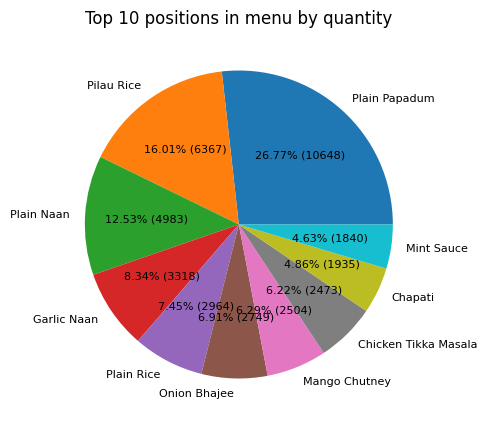

In [212]:
top_10_products.plot.pie(
    title="Top 10 positions in menu by quantity",
    autopct=lambda pct: f"{pct:.2f}% ({(pct/100)*top_10_products.sum():.0f})",
    figsize=(5, 5),
    fontsize=8,
    ylabel=""
)

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

In [240]:
df["TotalIncome"] = df["price"] * df["quantity"]
top_10_products = df.groupby("name")["TotalIncome"].sum().nlargest(10)
top_10_products

name
Chicken Tikka Masala    22133.35
Pilau Rice              18782.65
Plain Naan              12955.80
Korma                   12261.50
Bombay Aloo             10894.45
Onion Bhajee            10858.55
Butter Chicken          10626.60
Garlic Naan              9788.10
Korma - Chicken          9764.45
Plain Rice               8743.80
Name: TotalIncome, dtype: float64

<Axes: title={'center': 'Top 10 items in menu by total income'}>

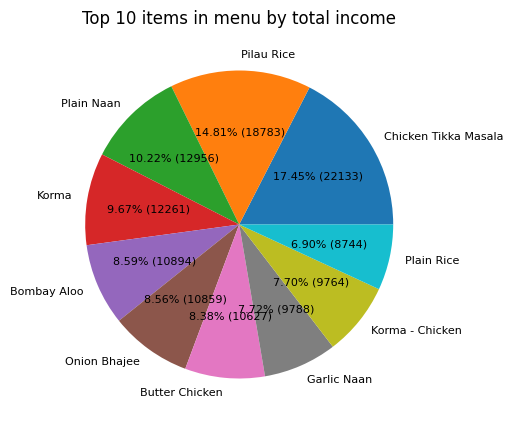

In [241]:
top_10_products.plot.pie(
    title="Top 10 items in menu by total income",
    autopct=lambda pct: f"{pct:.2f}% ({(pct/100)*top_10_products.sum():.0f})",
    figsize=(5, 5),
    fontsize=8,
    ylabel=""
)

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

<Axes: title={'center': 'Profit by Order Hour'}, xlabel='Order Hour', ylabel='Total Income'>

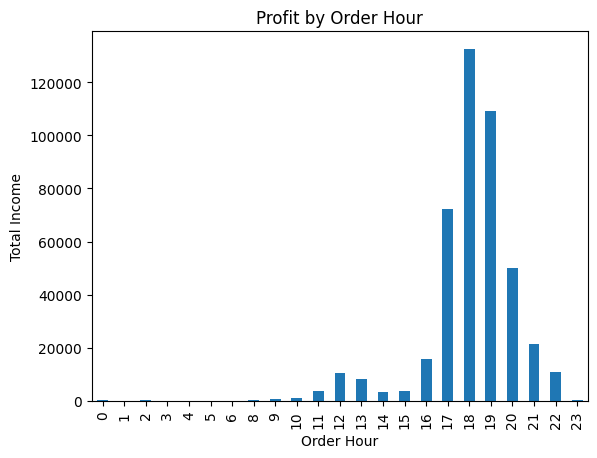

In [243]:
df["hour"] = df["datetime"].dt.hour
hourly_income = df.groupby("hour")["TotalIncome"].sum()
hourly_income.plot.bar(title="Profit by Order Hour", xlabel="Order Hour", ylabel="Total Income")

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

<Axes: title={'center': 'Profit by Order Weekday'}, xlabel='Order Weekday', ylabel='Total Income'>

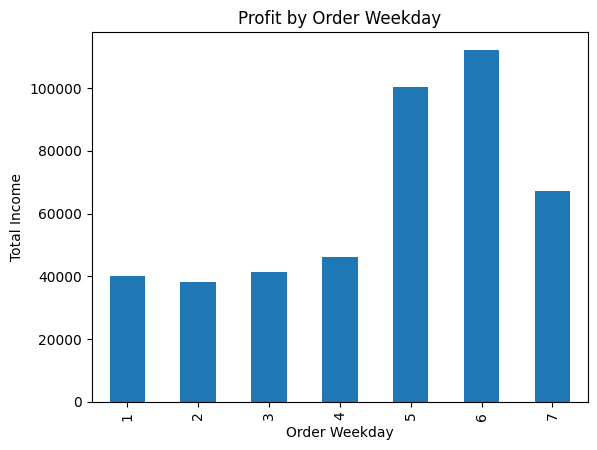

In [250]:
df["weekday"] = df["datetime"].dt.weekday + 1
hourly_income = df.groupby("weekday")["TotalIncome"].sum()
hourly_income.plot.bar(title="Profit by Order Weekday", xlabel="Order Weekday", ylabel="Total Income")